# О соревновании
Будучи вторым по величине поставщиком углеводов в Африке, маниока является ключевой культурой продовольственной безопасности, выращиваемой мелкими фермерами, поскольку она может выдерживать суровые условия, но вирусные заболевания являются основными источниками плохой урожайности. С помощью науки о данных можно выявить распространенные заболевания, чтобы их можно было лечить.

Существующие методы выявления болезней требуют, чтобы фермеры обращались за помощью к финансируемым государством сельскохозяйственным экспертам для визуального осмотра и диагностики растений. 

В этом конкурсе представляется набор данных из 21 367 помеченных изображений, собранных во время регулярного опроса в Уганде. Большинство изображений были получены от фермеров, фотографирующих свои сады, и аннотированы экспертами Национального исследовательского института сельскохозяйственных ресурсов (NaCRRI) в сотрудничестве с лабораторией искусственного интеллекта Университета Макерере в Кампале. 

Задача состоит в том, чтобы классифицировать каждое изображение маниоки на четыре категории болезней или пятую категорию, указывающую на здоровый лист. С вашей помощью фермеры смогут быстро идентифицировать больные растения, потенциально спасая свои посевы, прежде чем они нанесут непоправимый ущерб.

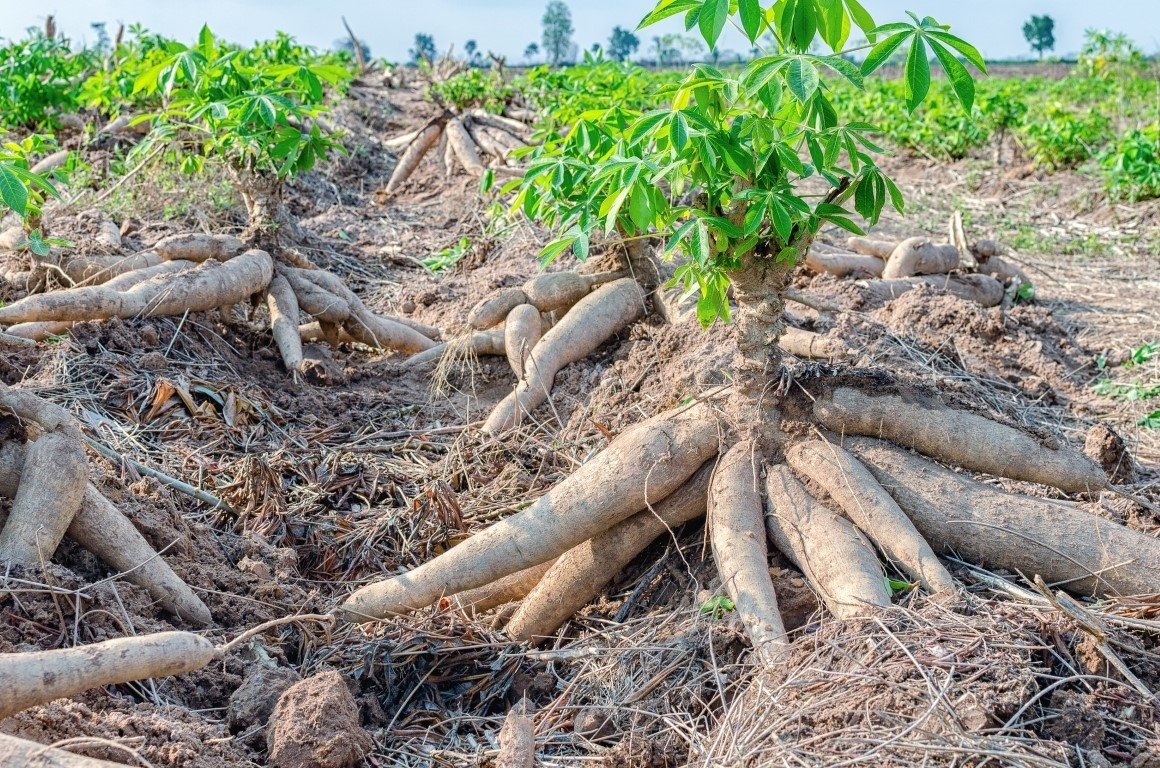
# От автора блокнота
Как всегда, это удобная для начинающих тетрадь, в которой я рассказываю вам , как вы можете эффективно стать врачом листьев со специализацией на болезнях листьев маниоки 😛 и с основной методологией глубокого обучения

Я расскажу обо всем , что вам нужно знать, от знаний о специализации до методологий с базовыми примерами различных идей, которые я предлагаю для решения проблемы.

Без особой путаницы вы можете следить за этой записной книжкой и сделать это своим первым живым конкурсом резюме

Если вы совершенно новичок в машинном обучении и kaggle, взгляните на это [руководство] (https://www.kaggle.com/tanulsingh077/tackling-any-kaggle-competition-the-noob-s-way) которое написал автор

В этом соревновании вы столкнулись с классической задачей классификации компьютерного зрения . Это отличная возможность для тех, кто только начал работать с резюме, попробовать свои силы в этом живом соревновании и сделать его своим первым . В довершение всего метрикой для этого соревнования является accuracy. 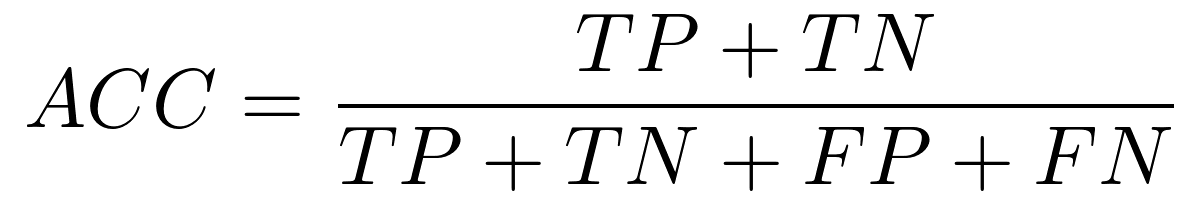


То, что на самом деле требуется от вас, - это стать фитопатологом и помочь фермерам идентифицировать инфекционные листья"

# Шаг 1: Анализ исследуемых данных

* Каким будет первый шаг, который должен сделать врач, прежде чем что-либо делать, учитывая тот факт, что его клиент не может говорить ?
Ответ прост, правильно, проанализируйте, что не так, глядя на пациента

* Но как врач понимает, что что-то не так, просто взглянув на пациента?
Для этого,нужно знать, как выглядит нормальный пациент/лист, и наблюдать отклонения (по рисунку, цвету, текстуре и т. д.) от нормального поведения, чтобы отделить здоровых пациентов от инфицированных . Теперь для дальнейшей классификации инфицированных в определенный класс заболеваний врач должен также знать, как выглядит состояние пациента/листа при различных заболеваниях

Имея в виду эти указатели давайте начнем с базового знакомства

In [ ]:
import sys
sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

In [ ]:
# Preliminaries
import os
from pathlib import Path
import glob
from tqdm import tqdm
tqdm.pandas()
import json
import pandas as pd
import numpy as np

## Image hash
import imagehash

# Visuals and CV2
import seaborn as sn
import matplotlib.pyplot as plt
import cv2
from PIL import Image


# albumentations for augs
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Keras and TensorFlow
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array 
from keras.applications.resnet50 import preprocess_input 

# models 
from keras.applications.resnet50 import ResNet50
from keras.models import Model

#torch
import torch
import timm
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader

# Utils

Section for Utility Functions

In [ ]:
def plot_images(class_id, label, images_number,verbose=0):
    '''
    Courtesy of https://www.kaggle.com/isaienkov/cassava-leaf-disease-classification-data-analysis
    '''
    plot_list = train[train["label"] == class_id].sample(images_number)['image_id'].tolist()
    
    # Printing list of images
    if verbose:
        print(plot_list)
        
    labels = [label for i in range(len(plot_list))]
    size = np.sqrt(images_number)
    if int(size)*int(size) < images_number:
        size = int(size) + 1
        
    plt.figure(figsize=(20, 20))
    
    for ind, (image_id, label) in enumerate(zip(plot_list, labels)):
        plt.subplot(size, size, ind + 1)
        image = cv2.imread(str(BASE_DIR/'train_images'/image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(label, fontsize=12)
        plt.axis("off")
    
    plt.show()

In [ ]:
BASE_DIR = Path('../input/cassava-leaf-disease-classification')

## Reading DataFrame having Labels
train = pd.read_csv(BASE_DIR/'train.csv')

## Label Mappings
with open(BASE_DIR/'label_num_to_disease_map.json') as f:
    mapping = json.loads(f.read())
    mapping = {int(k): v for k,v in mapping.items()}

print(mapping)

<b>Как мы видим, у нас есть 4 болезни, о которых мы должны будем узнать в этом курсе doctoe , мы погрузимся глубже в каждую из них, одну за другой обрамляя наше понимание характеристик и других вещей, но перед этим давайте сопоставим эти названия болезней с метками в нашем наборе данных </b>

In [ ]:
train['label_names'] = train['label'].map(mapping)
train.head()

## Шаг 1.1 изучение здоровых

Теперь у нас есть все в одном месте, мы можем начать смотреть на здоровые образы и формировать наше понимание характеристик здоровых листьев маниоки . "Ниже приведено изображение здорового листа маниоки из Google`

![](https://cdn.shortpixel.ai/client/to_avif,q_lossless,ret_img,w_795,h_532/https://organic.ng/wp-content/uploads/2017/02/CASSAVA-LEAF.jpg)

* Из приведенного выше изображения мы можем сказать, что одной из характеристик здорового листа маниоки является то, что он должен быть довольно зеленым и вертикальным без особых разрезов, изменения текстуры , желтоватого градиента и т. д.

Давайте теперь посмотрим на здоровые из них в наборе данных и посмотрим, находятся ли они в близком смешении с приведенным выше изображением

In [ ]:
train[train['label_names']=='Healthy']['image_id'].count()

* Из 21К изображений только 2577 являются здоровыми, дисбаланс в метках отчетливо виден

In [ ]:
plot_images(class_id=4, 
    label='Healthy',
    images_number=6,verbose=1)

Теперь, если вы выполните описанную выше функцию три-четыре раза и внимательно наблюдаете за различными изображениями, которые вы видите каждый раз, вы поймете следующее :
* Не все изображения имеют листья крупным планом , некоторые изображения могут иметь все дерево с листьями, едва видимыми человеческому глазу , некоторые показывают больше стебля, чем листьев, то есть набор изображений довольно шумный
* Что еще более удивительно, так это то, что некоторые изображения здоровых листьев выглядят так, как будто они заражены, и показывают желтый или желтоватый градиентный тип цвета , что должно быть крайне маловероятно (нам придется исследовать это)

### Расследование Выбросов :
Чтобы исследовать пункт 2, у меня есть следующая идея :

* Идея здесь состоит в том, чтобы сгруппировать здоровые изображения и посмотреть на соответствующие кластеры, чтобы увидеть, можем ли мы найти выброшенный кластер и поврежденный кластер.
* * Мы будем использовать Resnet 18 для генерации функций для кластеризации

In [ ]:
def extract_features(image_id, model):
    file = BASE_DIR/'train_images'/image_id
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    
    return features

In [ ]:
model = ResNet50()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

healthy = train[train['label']==4]
healthy['features'] = healthy['image_id'].progress_apply(lambda x:extract_features(x,model))

In [ ]:
features = np.array(healthy['features'].values.tolist()).reshape(-1,2048)
image_ids = np.array(healthy['image_id'].values.tolist())

# Clustering
kmeans = KMeans(n_clusters=5,n_jobs=-1, random_state=22)
kmeans.fit(features)

In [ ]:
groups = {}
for file, cluster in zip(image_ids,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [ ]:
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 25")
        start = np.random.randint(0,len(files))
        files = files[start:start+25]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(5,5,index+1);
        img = load_img(BASE_DIR/'train_images'/file)
        img = np.array(img)
        plt.imshow(img)
        plt.title(file)
        plt.axis('off')

In [ ]:
view_cluster(3)

 Нам удалось сгруппировать большинство выбросов в кластере 3, и мы можем легко визуализировать их

* Мы видим, что есть довольно много листьев, которые кажутся поврежденными , имеют коричневые пятна и т. д. И кажутся нездоровыми

Существует множество дискуссионных тем, посвященных одной и той же теме :
* https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/198363 -- неправильные ярлыки
* https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/199606 -- качество этикеток

Теперь мы не должны беспокоиться о шуме в обучающем наборе , но что делать, если шум содержится в тестовом наборе и маркировка выполняется аналогично , тогда это может быть проблемой , мы не можем ничего удалить из обучающего набора, пока не будем уверены


Итак, теперь давайте подведем итоги этого раздела

"Характеристики здоровых листьев маниоки`:
* В основном зеленый цвет, прямостоячий, с небольшим количеством коричневых пятен или без них
* Равномерная текстура по всему листу, будь то желтый или зеленый

### Изучение болезни 1: бактериальная болезнь маниоки (CBB)

Теперь, когда мы знаем, как выглядит здоровый лист маниоки, давайте перейдем к изучению первой болезни . Во-первых, " симптомы CBB`:

* черные пятна на листьях и гнили, угловатые пятна на листьях, а также преждевременное высыхание и осыпание листьев из-за увядания молодых листьев
и сильного поражения.

Сначала на листьях появляются угловатые, пропитанные водой пятна, ограниченные жилками; пятна более отчетливо видны на нижней поверхности листа. Пятна быстро расширяются, соединяются, особенно по краям листьев, и становятся коричневыми с желтыми краями (Рис. 1).)

Капельки кремово-белого ила появляются в центре пятен; позже они желтеют.

![](https://www.pestnet.org/fact_sheets/assets/image/cassava_bacterial_blight_173/thumbs/cassavabb_sml.jpg)
![](https://www.pestnet.org/fact_sheets/assets/image/cassava_bacterial_blight_173/thumbs/cassavabb2_sml.jpg)


Чтобы узнать больше,[here](https://www.pestnet.org/fact_sheets/cassava_bacterial_blight_173.htm)

In [ ]:
plot_images(class_id=0, 
    label='CBB',
    images_number=6,verbose=1)

* Итак, исходя из наших знаний о симптомах, мы можем точно сказать , что у них есть болезнь CBB, и теперь мы также знаем, что получение изображения стебля вместо самого листа может быть не так уж и неправильно, потому что о некоторых заболеваниях можно судить и по стеблю, так что изображения, имеющие стебель, могут быть не шумовыми, в конце концов, после просмотра 6-7 различных наборов , кажется, нет никаких выбросов в этой категории.

* В некоторых изображениях, таких как IMG - '1926670152.jpg" коричневое пятно очень-очень маленькое, и лист больше похож на здоровый, и многие здоровые изображения также имеют такой маленький коричневый цвет, и их может быть трудно идентифицировать

* Исходя из моего понимания болезни в этой категории, я могу сказать, что случайное обрезание, изменение контраста , изменение цвета любого рода может быть не очень хорошей идеей

### Изучение болезни 2: Зеленая Крапинка маниоки (CGM)

Переходим к следующему заболеванию - " симптомам ЦГМ`:

* Это заболевание вызывает белые пятна на листьях, которые увеличиваются от первоначальных небольших пятен, чтобы покрыть весь лист, вызывая
потерю хлорофилла. Молодые листья сморщены со слабыми или отчетливыми желтыми пятнами (Рис. 1)

* Листья с этим заболеванием проявляют пятнистые симптомы, которые можно спутать с симптомами мозаичной болезни маниоки (ЦМД). Сильно поврежденный
листья сморщиваются, высыхают и опадают, что может привести к характерному свечному виду. (рис. 2)


![](https://www.pestnet.org/fact_sheets/assets/image/cassava_green_mottle_068/thumbs/cgmv2_sml.jpg)
![](https://www.pestnet.org/fact_sheets/assets/image/cassava_green_mottle_068/thumbs/cgmv_sml.jpg)

Чтобы узнать больше посетите сайт [here](https://www.pestnet.org/fact_sheets/cassava_green_mottle_068.htm)

In [ ]:
plot_images(class_id=2, 
    label='CGM',
    images_number=12,verbose=1)

#### Выводы

* Прочитав симптомы CGM и просмотрев изображения из набора данных, мы можем четко определить разницу между листьями CGM, листьями CBB и здоровыми листьями.
* Листья CGM имеют слабые или желтые пятна на листьях вдоль венчиков, листья CBB имеют коричневые пятна , а здоровые листья либо полностью зеленые, либо полностью желтые .
* Кроме того, в этом классе также не так много выбросов


### Изучение болезни 3 : мозаичная болезнь маниоки (CMD)

"Симптомы ЦМД`:

* ЦМД вызывает различные внекорневые симптомы, которые включают мозаику, пятнистость, деформированные и скрученные листочки, а также
общее уменьшение размеров листьев и растений .

* Листья, пораженные этим заболеванием, имеют пятна нормального зеленого цвета, смешанные с различными пропорциями желтого и белого в зависимости от тяжести заболевания .


In [ ]:
plot_images(class_id=3, 
    label='CMD',
    images_number=6,verbose=1)

### Выводы

* Мы видим, что CGM и CMD имеют очень близкие симптомы, а также имеют довольно похожие изображения , часто эксперты могут запутаться, обозначая их, мы можем только представить, насколько большой проблемой это будет для модели

* Похоже, что в этой категории также нет или очень мало выбросов

In [ ]:
plot_images(class_id=1, 
    label='CBSD',
    images_number=12,verbose=1)

* Давайте попробуем и посмотрим, сможем ли мы получить кластер изображений Tubular Root Images из данных

In [ ]:
CBSD = train[train['label']==1]
CBSD['features'] = CBSD['image_id'].progress_apply(lambda x:extract_features(x,model))

In [ ]:
features_cbsd = np.array(CBSD['features'].values.tolist()).reshape(-1,2048)
image_ids_cbsd = np.array(CBSD['image_id'].values.tolist())

# Clustering
kmeans_cbsd = KMeans(n_clusters=5,n_jobs=-1, random_state=22)
kmeans_cbsd.fit(features_cbsd)

In [ ]:
groups_cbsd = {}
for file, cluster in zip(image_ids_cbsd,kmeans_cbsd.labels_):
    if cluster not in groups_cbsd.keys():
        groups_cbsd[cluster] = []
        groups_cbsd[cluster].append(file)
    else:
        groups_cbsd[cluster].append(file)

In [ ]:
def view_cluster(cluster):
    plt.figure(figsize = (25,25))
    # gets the list of filenames for a cluster
    files = groups_cbsd[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 25")
        start = np.random.randint(0,len(files))
        files = files[start:start+25]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(5,5,index+1);
        img = load_img(BASE_DIR/'train_images'/file)
        img = np.array(img)
        plt.imshow(img)
        plt.title(file)
        plt.axis('off')

In [ ]:
view_cluster(4)

* We were successfully able to cluster the Tubular Root Images into one cluster of 80 Images and hence now we can get all the IDS and might think of Various Ideas on how to use this information

# Краткое изложение наших выводов: конец шага 1

Давайте подведем итог нашим выводам из нашего первоначального EDA :

* Здоровые изображения могут быть неправильно помечены, неправильно помеченные изображения можно найти в  3 из 5 кластерах.
* Полностью желтые листья не всегда могут указывать на потенциальную болезнь листа .
* Коричневые пятна на листьях свидетельствуют о бактериальном поражении маниоки
* Все изображения имеют множество различных фонов и масштабов
* Изображения были сняты в разное время суток, и поэтому они имеют различное освещение и экспозицию .
* Маниока Зеленая Крапинка (CGM) и маниока мозаичная болезнь (CMD) имеют очень похожие симптомы, а также изображения и могут быть легко ошибочно помечены друг за друга . Кроме того , поскольку существует 13 тысяч примеров болезни маниоки Мосиака, весьма вероятно, что большинство ошибок совершается моделью при маркировке CGM как CGM
* Одно изображение / растение маниоки может содержать несколько сопутствующих заболеваний . Модель сочла бы это сбивающим с толку ярлыком
* CBSD имеет два вида изображений в наборе данных , одно из которых представляет собой растение/листья, а другое-корни, которые могут быть легко неправильно истолкованы как картофель или какой-то случайный шум , мы можем сгруппировать все такие изображения в кластер номер 4


Первый шагзавершен, мы успешно поняли нашего пациента и различные болезни, которые могут возникнуть. Этот шаг поможет нам разработать уникальные решения / планы для создания лучшего решения .

In [ ]:
funcs = [
        imagehash.average_hash,
        imagehash.phash,
        imagehash.dhash,
        imagehash.whash,
    ]

image_ids = []
hashes = []

for path in tqdm(glob.glob(str(BASE_DIR/'train_images'/'*.jpg' ))):
    image = Image.open(path)
    image_id = os.path.basename(path)
    image_ids.append(image_id)
    hashes.append(np.array([f(image).hash for f in funcs]).reshape(256))

In [ ]:
hashes_all = np.array(hashes)

Преобразуйте массив numpy в torch тензор, чтобы ускорить вычисление подобия.

In [ ]:
hashes_all = torch.Tensor(hashes_all.astype(int)).cuda()

Вычислите сходство между всеми парами изображений. Разделите значение на 256, чтобы нормализовать (0-1).

In [ ]:
%time sims = np.array([(hashes_all[i] == hashes_all).sum(dim=1).cpu().numpy()/256 for i in range(hashes_all.shape[0])])

Thresholding

In [ ]:
indices1 = np.where(sims > 0.9)
indices2 = np.where(indices1[0] != indices1[1])
image_ids1 = [image_ids[i] for i in indices1[0][indices2]]
image_ids2 = [image_ids[i] for i in indices1[1][indices2]]
dups = {tuple(sorted([image_ids1,image_ids2])):True for image_ids1, image_ids2 in zip(image_ids1, image_ids2)}
print('found %d duplicates' % len(dups))

Построение дубликатов изображений

In [ ]:
'''
code taken from https://www.kaggle.com/nakajima/duplicate-train-images?scriptVersionId=47295222
'''

duplicate_image_ids = sorted(list(dups))

fig, axs = plt.subplots(2, 2, figsize=(15,15))

for row in range(2):
        for col in range(2):
            img_id = duplicate_image_ids[row][col]
            img = Image.open(str(BASE_DIR/'train_images'/img_id))
            label =str(train.loc[train['image_id'] == img_id].label.values[0])
            axs[row, col].imshow(img)
            axs[row, col].set_title("image_id : "+ img_id + "  label : " + label)
            axs[row, col].axis('off')

У нас есть другие методы поиска дубликатов, которые помогут нам идентифицировать более мягкие дубликаты, если таковые имеются в наборе данных , которые появятся в более поздних версиях этого ядра

# Шаг 2: изучение методологии

Здравствуйте, врачи добро пожаловать на ваш второй курс, для того чтобы завершить ваше окончательное задание, теперь вам нужно понять инструменты, которые у вас есть в вашем распоряжении, и как их использовать , Ниже приведено пошаговое руководство, которому нужно следовать, чтобы изучить эти инструменты

* [Beginner Article](https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks/)
* [Course By Andrew NG](https://www.coursera.org/learn/convolutional-neural-networks)
* [Applying CNNS using Keras and tensorflow](https://www.coursera.org/learn/convolutional-neural-networks-tensorflow)
* [Course from Fast.ai](https://course.fast.ai/videos/?lesson=1)

# Шаг 3: Создание Окончательного Проекта


Хорошо, теперь, документы, пришло время для вас, чтобы построить окончательный проект . Поскольку это окончательный проект, он предназначен для того , чтобы каждый был построен сам по себе, здесь я просто напишу краткое изложение того, что я использовал, а также предложу способы дальнейшего улучшения проекта.

Наконец, я также добавляю вещи, которые нужно попробовать / посмотреть на протяжении всего конкурса

"Краткое изложение базовой модели":

Эта модель основана на победившем решении конкурса Cassava 2019 и я постараюсь воспроизвести ее как можно ближе:

* SE-ResNext50
* Dimension = (384,384)
* Epochs = 10
* Custom LR scheduler 
* Weights saved on best loss : Categorical CrossEntropy
* Basic Augs : HorizontalFlip,VerticalFlip,Rotate,RandomBrightness,ShiftScaleRotate,cutout,centercrop,zoom,randomscale
* No TTA

<font color ='red' >Note : As I am limited to kaggle for GPU's my five folds model is still running and hence for now I just use the pretrained weights of SeResNext50 , This notebook will be updated several times with different configs /ideas so keep tuning in</color>

## Configuration and utility Functions

In [ ]:
DIM = (384,384)

NUM_WORKERS = 12
TEST_BATCH_SIZE = 16
SEED = 2020

DEVICE = "cuda"

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

## Augmentations

In [ ]:
def get_test_transforms():

    return albumentations.Compose(
        [albumentations.Normalize(MEAN, STD, max_pixel_value=255.0, always_apply=True),
        ToTensorV2(p=1.0)
        ]
    )

# Cassava Dataset

In [ ]:
class CassavaDataset(Dataset):
    def __init__(self,image_ids,labels,dimension=None,augmentations=None):
        super().__init__()
        self.image_ids = image_ids
        self.labels = labels
        self.dim = dimension
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self,idx):
        
        img = cv2.imread(str(BASE_DIR/'test_images'/self.image_ids[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                         
        if self.dim:
            img = cv2.resize(img,self.dim)
        
        if self.augmentations:
            augmented = self.augmentations(image=img)
            image = augmented['image']
                         
        return {
            'image': image,
            'target': torch.tensor(self.labels[idx],dtype=torch.float)
        }

# Model : SE_Resnext50

In [ ]:
class CassavaModel(nn.Module):
    def __init__(self, model_name='seresnext50_32x4d',out_features=5,pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        
        n_features = self.model.last_linear.in_features
        self.model.last_linear = nn.Linear(n_features, out_features)

    def forward(self, x):
        x = self.model(x)
        return x

# Prediction Function Single Model

In [ ]:
def predict_single_model(data_loader,model,device):
    model.eval()
    tk0 = tqdm(enumerate(data_loader), total=len(data_loader))
    fin_out = []
    
    with torch.no_grad():
        
        for bi, d in tk0:
            images = d['image']
            targets = d['target']
            
            images = images.to(device)
            targets = targets.to(device)
            
            batch_size = images.shape[0]
            
            outputs = model(images)
            
            fin_out.append(F.softmax(outputs, dim=1).detach().cpu().numpy())
            
    return np.concatenate(fin_out)

# Engine

In [ ]:
sample_sub = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')

In [ ]:
def predict(weights):
    '''
    weights : List of paths in case of K fold model inference
    '''
    pred = np.zeros((len(sample_sub),5,5))
    
    # Defining DataSet
    test_dataset = CassavaDataset(
        image_ids=sample_sub['image_id'].values,
        labels=sample_sub['label'].values,
        augmentations=get_test_transforms(),
        dimension = DIM
    )
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=TEST_BATCH_SIZE,
        num_workers=NUM_WORKERS,
        shuffle=False,
        pin_memory=True,
        drop_last=False,
    )
    
    # Defining Device
    device = torch.device("cpu")
    
    for i,weight in enumerate(weights):
        # Defining Model for specific fold
        model = CassavaModel(out_features=5,pretrained=True)
        
        # loading weights
        #model.load_state_dict(torch.load(weight))
        model.to(device)
        
        #predicting
        pred[:,:,i] = predict_single_model(test_loader,model,device)
    
    return pred

# Preparing Final Submission

In [ ]:
pred = predict([1])
print(pred)

In [ ]:
pred = pred.mean(axis=-1)
print('Prediction Before Argmax',pred)
pred = pred.argmax(axis=1)
print('Final Prediction',pred)

In [ ]:
sample_sub['label'] = pred
sample_sub.head()

In [ ]:
sample_sub.to_csv('submission.csv',index=False)

# Conclusion

There is a lot to try as the competition is just starting , I will try to keep this notebook updated

Thanks for reading my notebook , I hope you got something helpful out of it